In [1]:
%cd /Users/jingsun/Desktop/UVA/fall18/sys6018/kaggle/data

/Users/jingsun/Desktop/UVA/fall18/sys6018/kaggle/data


In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer

In [172]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.describe()

,post.id,user.id,age
count,442961.000000,442961.000000,442961.000000
mean,340076.005231,9655.198203,23.540594
std,196532.771521,5512.481177,7.603127
min,1.000000,1.000000,13.000000
25%,168419.000000,4760.000000,17.000000
50%,341752.000000,9630.000000,24.000000
75%,510601.000000,14278.000000,26.000000
max,681161.000000,19319.000000,48.000000


In [4]:
print(train.shape)
print(test.shape)
train.drop(['post.id','date'], axis=1, inplace=True)

(442961, 8)
(238323, 7)


In [5]:
train.head()

,user.id,gender,topic,sign,text,age
0,11869,male,Student,Leo,"Info has been found (+/- 100 pages,...",15
1,11869,male,Student,Leo,These are the team members: Drewe...,15
2,11869,male,Student,Leo,In het kader van kernfusie op aarde...,15
3,11869,male,Student,Leo,testing!!! testing!!!,15
4,16332,male,InvestmentBanking,Aquarius,Thanks to Yahoo!'s Toolbar I can ...,33


In [6]:
train_nodup = train.drop_duplicates()
print(train_nodup.shape)

(438369, 6)


In [7]:
train_nodup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438369 entries, 0 to 442960
Data columns (total 6 columns):
user.id    438369 non-null int64
gender     438369 non-null object
topic      438369 non-null object
sign       438369 non-null object
text       438369 non-null object
age        438369 non-null int64
dtypes: int64(2), object(4)
memory usage: 23.4+ MB


In [9]:
train_groupby = train_nodup.groupby(['user.id','topic','age'])['text'].apply(''.join).reset_index()
train_groupby.head()

,user.id,topic,age,text
0,1,indUnk,17,Doritos Fuel of Space urlLink : Ian My...
1,3,indUnk,16,"Yeah, I set up this blog so Heather w..."
2,4,Student,17,Not too much exciting has happened ...
3,5,Accounting,47,European Pilgrimage For High sch...
4,6,Student,16,Last night's dream is very blurry. T...


In [147]:
topicList = train_groupby['topic'].unique().tolist()
len(topicList)

40

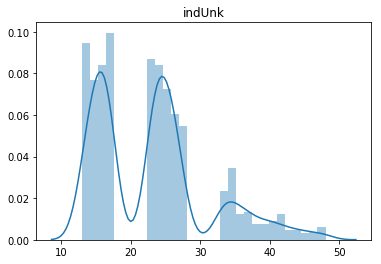

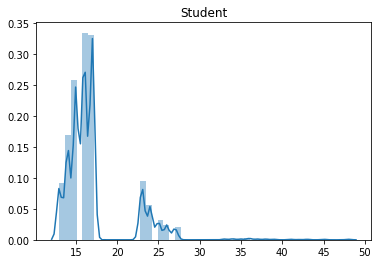

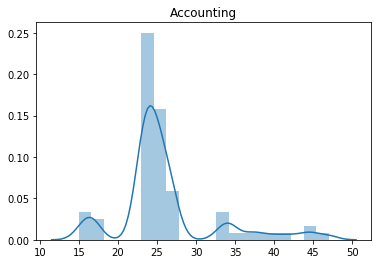

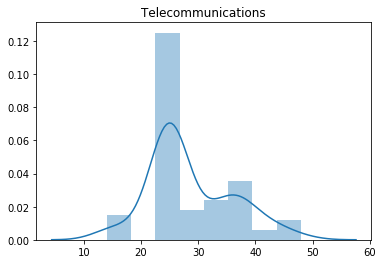

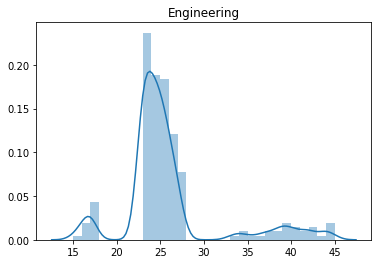

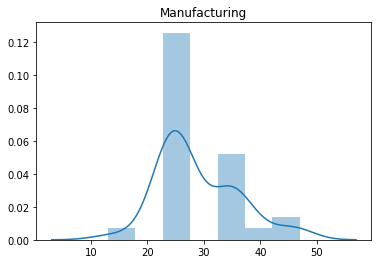

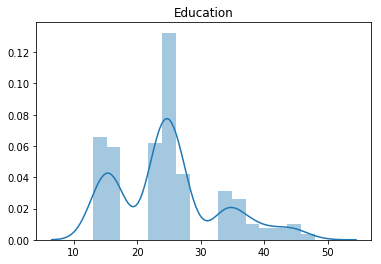

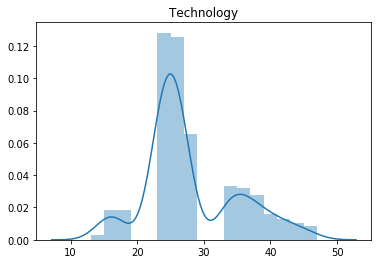

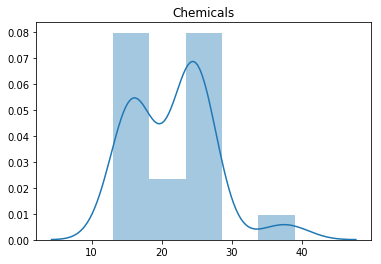

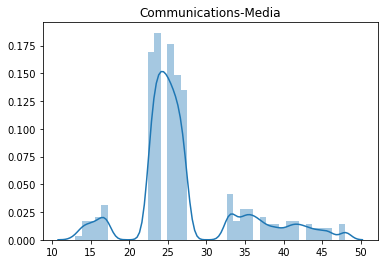

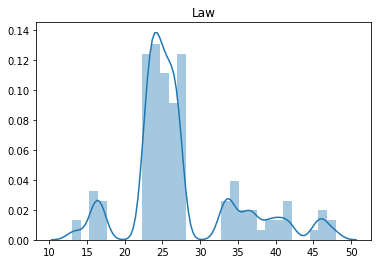

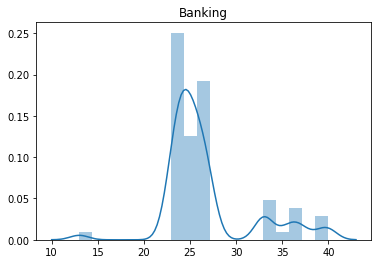

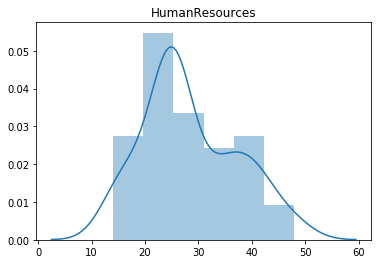

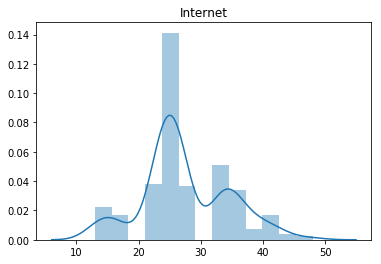

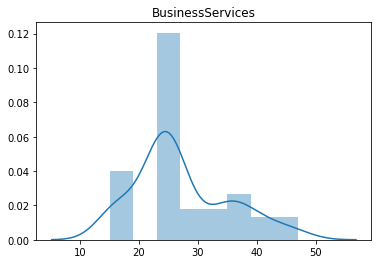

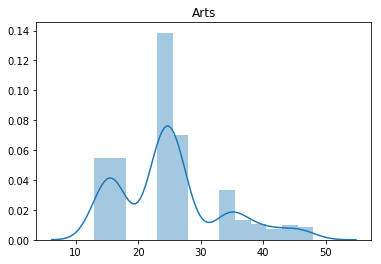

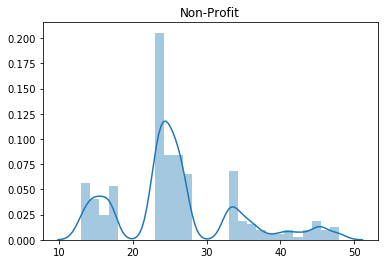

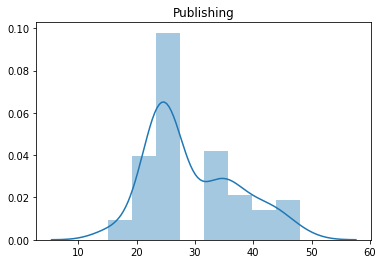

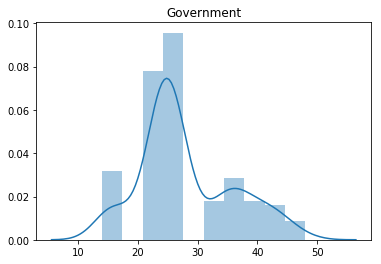

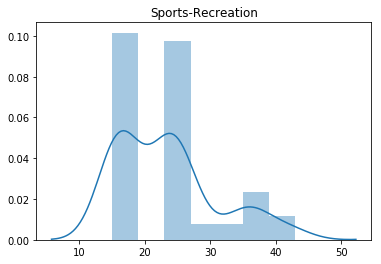

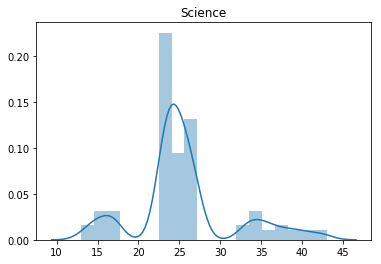

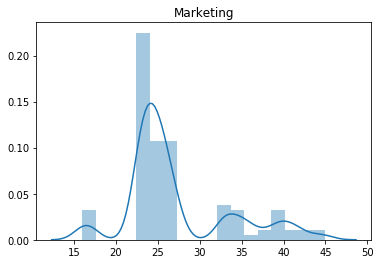

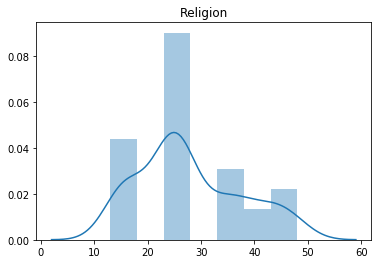

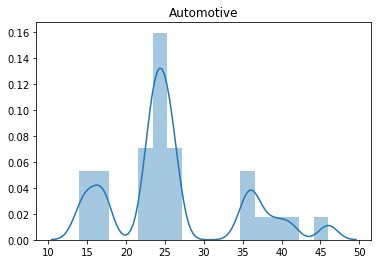

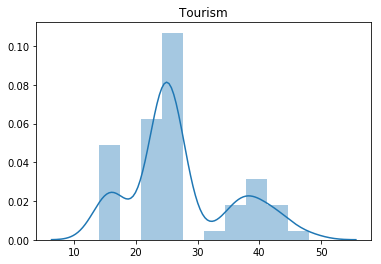

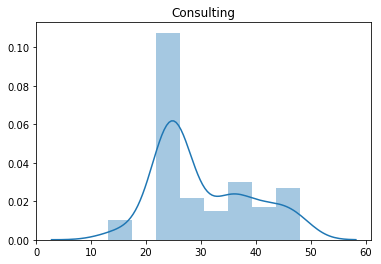

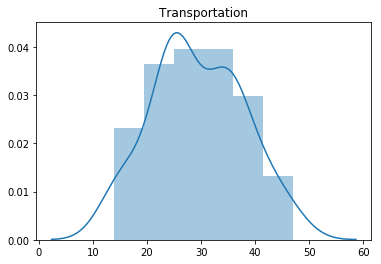

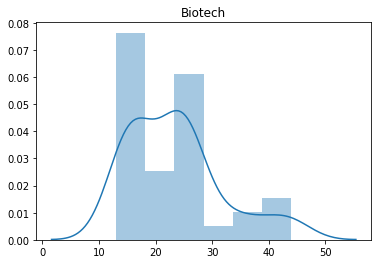

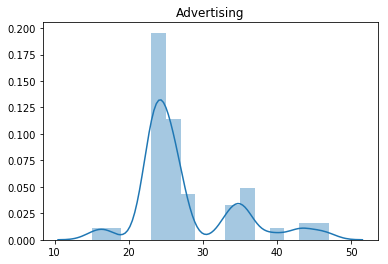

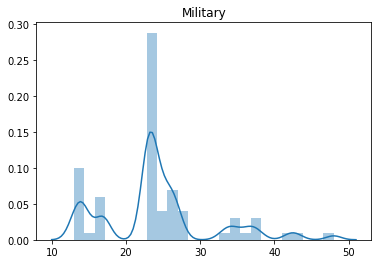

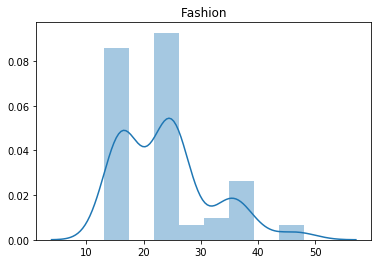

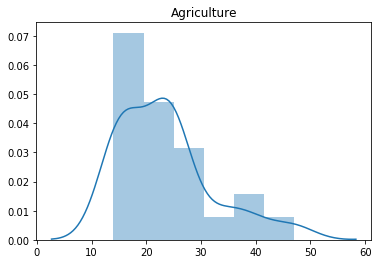

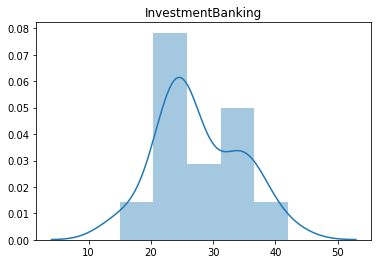

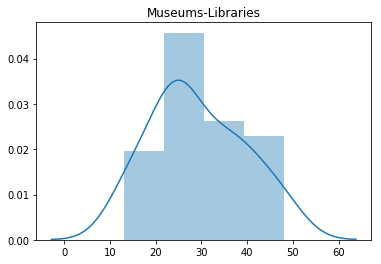

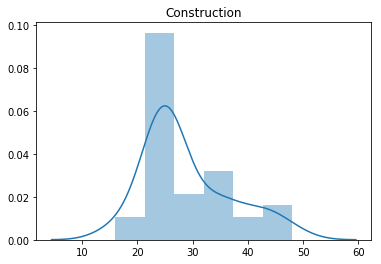

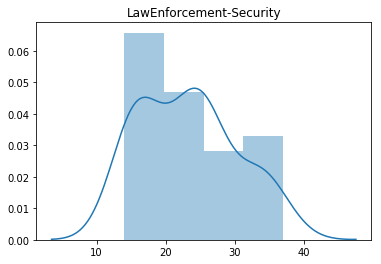

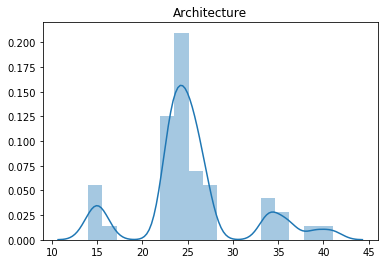

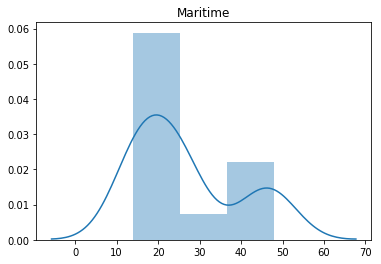

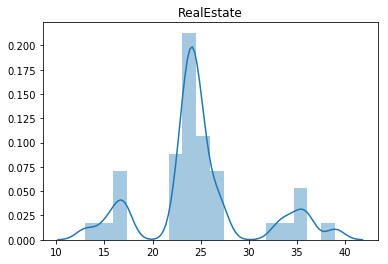

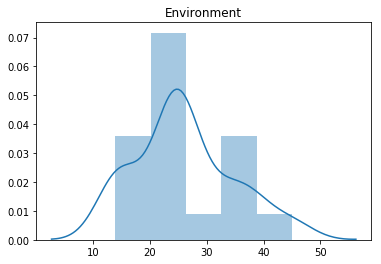

In [10]:
for t in topicList:
    ageList = train_groupby[train_groupby['topic'] == t]['age'].tolist()
    sns.distplot(ageList).set_title(t)
    plt.show()

In [15]:
#posts = train_groupby['text'].tolist()

In [12]:
#vectorizer = CountVectorizer(lowercase=True, stop_words='english')
#matrix = vectorizer.fit_transform(posts)
#freq = matrix.todense()
#print(freq.shape)

(12880, 547358)


In [16]:
X = train_groupby

In [239]:
X_train = X[:-5152]
X_test = X[-5152:]
Y_train = train_groupby['age'][:-5152]
Y_test = train_groupby['age'][-5152:]

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(7728, 4)
(5152, 4)
(7728,)
(5152,)


In [82]:
posts = X_train['text'].to_string()

In [86]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from collections import Counter

tokens = word_tokenize(posts)
words = [word.lower() for word in tokens if word.isalpha()] # filter out punctuation
table = str.maketrans('','',string.punctuation)
stripped = [w.translate(table) for w in words]
print(len(stripped))

stop_words = stopwords.words('english')
words = [w for w in stripped if not w in stop_words]
print(len(words))

porter = PorterStemmer()
stemmed = [porter.stem(word) for word in words]
print(len(stemmed))

53073
28023
28023


In [240]:
count = Counter(stemmed)
mostcommon = count.most_common(50)
words = [w[0] for w in mostcommon if len(w[0]) > 1 and w[0] != 'urllink']
len(words)

47

In [228]:
postList = X_train['text'].tolist()
vectorizer = CountVectorizer(vocabulary = words)
matrix = vectorizer.fit_transform(postList)
freq = matrix.todense()
print(freq.shape)

(7728, 47)


In [241]:
kkk = pd.get_dummies(X_train,columns=['topic'])
type(kkk)

pandas.core.frame.DataFrame

In [242]:
freq_df = pd.DataFrame(freq)
freq_df['user.id'] = kkk['user.id'].tolist()

In [243]:
new_train = pd.merge(kkk, freq_df, how='left',on='user.id')
new_train.shape

(7728, 90)

In [244]:
new_train = new_train.drop(['user.id','text'], axis=1)

In [245]:
X_new_train = new_train.drop('age',axis=1)
Y_new_train = new_train['age']
print(X_new_train.shape)
print(Y_new_train.shape)

(7728, 87)
(7728,)


In [246]:
from sklearn.linear_model import Lasso, LinearRegression
X_new_train.values

array([[ 0,  0,  0, ...,  3,  2,  0],
       [ 0,  0,  0, ...,  1,  1,  1],
       [ 0,  0,  0, ...,  0,  3,  0],
       ...,
       [ 0,  0,  0, ...,  5, 11,  9],
       [ 0,  0,  0, ...,  0,  3,  0],
       [ 0,  0,  0, ...,  0,  3,  0]])

In [247]:
lr = LinearRegression()
LRMd = lr.fit(X_new_train.values,Y_new_train)
np.mean(abs(Y_new_train - LRMd.predict(X_new_train.values)))

5.023778570611531

VALIDATION

In [252]:
X_test = pd.get_dummies(X_test,columns=['topic'])

In [248]:
postList = X_test['text'].tolist()
vectorizer = CountVectorizer(vocabulary = words)
matrix = vectorizer.fit_transform(postList)
freq = matrix.todense()
print(freq.shape)

(5152, 47)


In [253]:
freq_df = pd.DataFrame(freq)
freq_df['user.id'] = X_test['user.id'].tolist()
new_test = pd.merge(X_test, freq_df, how='left',on='user.id')
new_test.shape

(5152, 90)

In [254]:
new_test = new_test.drop(['user.id','text'], axis=1)
X_new_test = new_test.drop('age',axis=1)
Y_new_test = new_test['age']
print(X_new_test.shape)
print(Y_new_test.shape)

(5152, 87)
(5152,)


In [255]:
np.mean(abs(Y_new_test - LRMd.predict(X_new_test.values)))

4.993801552316417

### test file

In [173]:
test.drop(['post.id','date'], axis=1, inplace=True)
test_nodup = test.drop_duplicates()

In [174]:
test_groupby = test_nodup.groupby(['user.id','topic'], sort=False)['text'].apply(''.join).reset_index()

topicList_test = test_groupby['topic'].unique().tolist()
len(topicList_test)

40

In [175]:
test_test = pd.get_dummies(test_groupby,columns=['topic'])

In [256]:
test_test.shape

(6440, 42)

In [257]:
postList = test_test['text'].tolist()
vectorizer = CountVectorizer(vocabulary = words)
matrix = vectorizer.fit_transform(postList)
freq = matrix.todense()
print(freq.shape)

(6440, 47)


In [258]:
freq_df = pd.DataFrame(freq)
freq_df['user.id'] = test_test['user.id'].tolist()
new_test = pd.merge(test_test, freq_df, how='left',on='user.id')
new_test.shape

(6440, 89)

In [259]:
new_test = new_test.drop(['user.id','text'], axis=1)
#Y_new_test = new_test['age']
print(new_test.shape)

(6440, 87)


In [260]:
pred = LRMd.predict(new_test.values)
pred

array([23.18684196, 15.05058861, 23.07512093, ..., 15.38673019,
       17.33584023, 17.36719322])

In [261]:
pred_df = pd.DataFrame({'user.id': test_groupby['user.id'].tolist(), 'age': list(pred)})
pred_df = pred_df.loc[:,['user.id','age']]

In [262]:
pred_df.to_csv('sub5.csv',index=False)